In [ ]:
%pip install -r requirements.txt

!for f in icon_detect/{train_args.yaml,model.pt,model.yaml} icon_caption/{config.json,generation_config.json,model.safetensors}; do hf download microsoft/OmniParser-v2.0 "$f" --local-dir weights; done
!mv weights/icon_caption weights/icon_caption_florence

# Nếu dùng transformers mới quá sẽ ko bị bỏ đi spda hoặc flashattention nên cần downgrade lại
%pip install transformers==4.49.0 

import util.utils as utils

yolo_model = utils.get_yolo_model(model_path='weights/icon_detect/model.pt')
caption_model_processor = utils.get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence")

# Test thử ảnh ban đầu
from PIL import Image
image_input = Image.open(f"./imgs/mspaint.png")

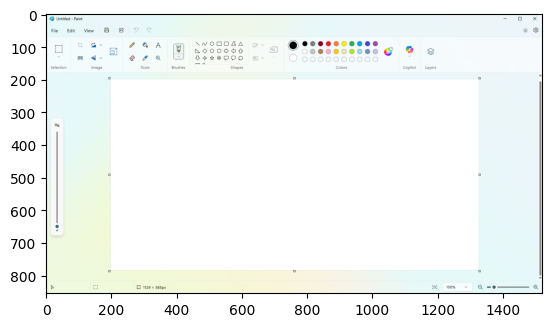

In [7]:
import matplotlib.pyplot as plt
plt.imshow(image_input)
plt.show()


0: 736x1280 82 icons, 17.6ms
Speed: 23.6ms preprocess, 17.6ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 86 9
time to get parsed content: 0.16132616996765137
finish processing


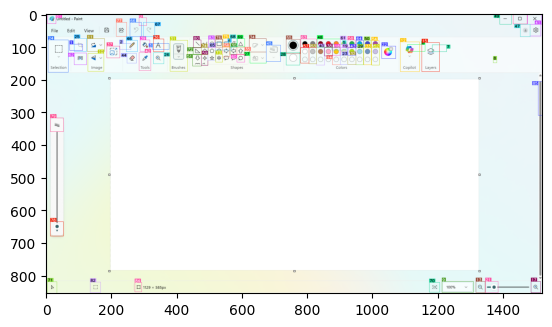

In [6]:
box_threshold = 0.05
iou_threshold = 0.1
use_paddleocr = True
imgsz = 1500
box_overlay_ratio = image_input.size[0] / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}

ocr_bbox_rslt, is_goal_filtered = utils.check_ocr_box(image_input, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=use_paddleocr)
text, ocr_bbox = ocr_bbox_rslt
dino_labled_img, label_coordinates, parsed_content_list = utils.get_som_labeled_img(image_input, yolo_model, BOX_TRESHOLD = box_threshold, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,iou_threshold=iou_threshold, imgsz=imgsz,)  

import io, base64
result_img = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
print('finish processing')
parsed_content_list = '\n'.join([f'icon {i}: ' + str(v) for i,v in enumerate(parsed_content_list)])

plt.imshow(result_img)
plt.show()


In [ ]:
#Dùng khi cần edit code và nạp lại module
from importlib import reload
import util.utils as utils

reload(utils)